# Configurables

In [17]:
# Configurable values that may or may not need to be changed per run
dir_location = 'internal' # Location that this run is on: internal, external, or cloud (i.e. OneDrive)
output_to_cloud = False # Overrides the output path to always output to the cloud (i.e. OneDrive)
is_original_data = True # Original data is the dataset used by the authors of ParticleSeg3D, False results in the DigiM tablet dataset
weights_tag = 'original_particle_seg' # Name of the weights that will be used
run_tag = 'original_dataset' # Name of the run, like what name will be used to label the outputs generated from this run
conda_env = 'Senior_Design_py310' # Name of conda environment containing all necessary libraries, packages, and modules

print('Values configured')

Values configured


# Set Paths

In [18]:
import os

# Set path to the base directory
if dir_location.lower() == 'internal':
    base_path = r'C:\Senior_Design'
elif dir_location.lower() == 'external':
    base_path = r'D:\Senior_Design'
elif dir_location.lower() == 'cloud':
    base_path = r'C:\Users\dchen\OneDrive - University of Connecticut\Courses\Year 4\Fall 2024\BME 4900 and 4910W (Kumavor)\Python\Files'
else:
    raise ValueError('Invalid directory location type')

# Set base paths to input, output, and weights        
base_input_path = os.path.join(base_path, 'database')
base_output_path = os.path.join(base_path, 'outputs')
if output_to_cloud:
    base_output_path = os.path.join(r'C:\Users\dchen\OneDrive - University of Connecticut\Courses\Year 4\Fall 2024\BME 4900 and 4910W (Kumavor)\Python\Files', 'outputs')
base_weights_path = os.path.join(base_path, 'weights')

# Set Zarr (model output) and TIFF (readable output) paths
output_zarr_path = os.path.join(base_output_path, 'zarr', run_tag)
output_tiff_path = os.path.join(base_output_path, 'tiff', run_tag)

# Set dataset path
if is_original_data:
    input_path = os.path.join(base_input_path, 'orignal_dataset', 'grayscale', 'dataset')
else:
    input_path = os.path.join(base_input_path, 'tablet_dataset', 'grayscale', 'dataset')

# Set weights path
weights_path = os.path.join(base_weights_path, weights_tag)

# Ensure paths with spaces or parentheses are quoted (for using the directory in OneDrive, does not matter if there are no spaces or parentheses)
input_path = f'"{input_path}"'
output_zarr_path = f'"{output_zarr_path}"'
output_tiff_path = f'"{output_tiff_path}"'
weights_path = f'"{weights_path}"'

print('Paths')

Paths


# Check CUDA Availability

In [11]:
import torch
torch.cuda.is_available()

True

# Run ParticleSeg3D Using Subprocess Module

In [ ]:
import subprocess

# Define the commands to execute in Anaconda PowerShell Prompt
activate_env = 'conda activate ' + conda_env
inference = 'ps3d_inference -i ' + input_path + ' -o ' + output_zarr_path + ' -m ' + weights_path
command = activate_env + '; ' + inference

# Run the commands
process = subprocess.run(
    ['powershell', '-Command', command], 
    stdout=subprocess.PIPE, 
    stderr=subprocess.PIPE, 
    text=True
)

# Output the results
print("STDOUT:", process.stdout)
print("STDERR:", process.stderr)

STDOUT: Samples:  ['Ore6', 'Slag3']
Starting inference of sample:  Ore6

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 77/77 [37:04<00:00, 28.89s/it]
Starting inference of sample:  Slag3

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 214/214 [2:01:59<00:00, 34.20s/it]

STDERR: C:\Users\dchen\anaconda3\envs\Senior_Design_py310\lib\site-packages\particleseg3d\inference\model_nnunet.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded 

# Convert Zarr Output to TIFF

In [19]:
import numpy as np
import os
import zarr
import tifffile
import subprocess

def safe_makedirs(path):
    """
    Safely create directories. If it fails due to invalid characters (e.g., quotes),
    it strips invalid characters and retries.
    """
    try:
        os.makedirs(path, exist_ok=True)
    except OSError as e:
        print(f"Error creating directory {path}: {e}")
        # Retry after stripping quotes
        cleaned_path = path.strip('"')
        print(f"Retrying with cleaned path: {cleaned_path}")
        try:
            os.makedirs(cleaned_path, exist_ok=True)
            path = cleaned_path
        except OSError as e2:
            print(f"Failed again with cleaned path {cleaned_path}: {e2}")
            raise e2  # Reraise the error if it still fails
        print()
    return path


def clean_path(path):
    """
    Strips invalid characters (e.g., quotes) from the path.
    """
    return path.strip('"')


def is_valid_zarr_directory(zarr_dir):
    """
    Validates the Zarr directory to ensure it exists and contains the required structure.
    Returns True if valid, otherwise False.
    """
    if not os.path.exists(zarr_dir):
        print(f"Error: Zarr directory {zarr_dir} does not exist.")
        print()
        return False

    if not os.path.isdir(zarr_dir):
        print(f"Error: {zarr_dir} is not a directory.")
        print()
        return False

    # Check if the directory contains valid subdirectories with `.zarr` files
    for image_name in os.listdir(zarr_dir):
        image_path = os.path.join(zarr_dir, image_name)
        zarr_file = os.path.join(image_path, f"{image_name}.zarr")
        if os.path.isdir(image_path) and os.path.exists(zarr_file):
            continue  # Valid image directory with a .zarr file
        else:
            print(f"Warning: {image_path} is missing a corresponding .zarr file.")
            print()
            return False

    return True


def convert_zarr_to_tiff(zarr_dir, tiff_dir):
    """
    Converts Zarr files to TIFF format, placing them directly in the `.tiff` folder.
    """
    print(f"Original Zarr Directory: {zarr_dir}")
    print(f"Original TIFF Directory: {tiff_dir}")
    print()

    # Try validating the Zarr directory
    try:
        # Attempt to list files in the Zarr directory
        os.listdir(zarr_dir)
    except OSError as e:
        print(f"Error accessing Zarr directory {zarr_dir}: {e}")
        # Clean path and retry
        zarr_dir = clean_path(zarr_dir)  # Update zarr_dir with the cleaned path
        print(f"Retrying with cleaned Zarr Directory: {zarr_dir}")
        # Check again with the cleaned path
        if not is_valid_zarr_directory(zarr_dir):
            print("Invalid Zarr directory after cleaning. Aborting conversion.")
            print()
            return
        print()

    # Ensure the output base directory exists for TIFF, and create the `.tiff` folder
    tiff_dir = safe_makedirs(tiff_dir)

    # Iterate through each folder in the Zarr directory
    for image_name in os.listdir(zarr_dir):
        image_path = os.path.join(zarr_dir, image_name)
        if os.path.isdir(image_path):
            zarr_input = os.path.join(image_path, f"{image_name}.zarr")

            print(f"Processing image: {image_name}")
            print(f"Zarr Input: {zarr_input}")
            print(f"TIFF Output Directory: {tiff_dir}")
            print()
            
            # Open Zarr dataset
            image_zarr = zarr.open(zarr_input, mode='r')

            # Convert Zarr data to uint8 (ensure it's within the valid range for uint8)
            if image_zarr.dtype != np.uint8:
                print("Converting data to float32...")
                for i in range(image_zarr.shape[0]):
                    image_slice = image_zarr[i]

                    # # Normalize or scale the data to the uint8 range (0-255)
                    # image_slice = np.clip(image_slice, 0, 255)  # Clip values to 0-255
                    # image_slice = image_slice.astype(np.uint8)   # Convert to uint8
                    image_slice = image_slice.astype(np.float32)   # Convert to float32

                    # Save the slice as a TIFF image
                    tiff_output_dir = os.path.join(tiff_dir, image_name)
                    tiff_output_dir = safe_makedirs(tiff_output_dir)
                    tifffile.imwrite(os.path.join(tiff_output_dir, f"{image_name}_{i}.tiff"), image_slice)
            else:
                try:
                    # Run the external command to convert Zarr to TIFF (does not seem to work, the generated TIFF images cannot be read...)
                    command = ["ps3d_zarr2tiff", "-i", zarr_input, "-o", tiff_dir]
                    result = subprocess.run(command, check=True, capture_output=True, text=True)
                    print(f"Converted {zarr_input} to {tiff_dir}")
                    print()
                    print("Standard Output:", result.stdout)
                    print("Standard Error:", result.stderr)
                except subprocess.CalledProcessError as e:
                    print(f"Error converting {zarr_input} to TIFF: {e}")
                    print()
                except Exception as e:
                    print(f"Unexpected error while processing {image_name}: {e}")
                    print()

In [20]:
# Convert Zarr files to TIFF
convert_zarr_to_tiff(output_zarr_path, output_tiff_path)

Original Zarr Directory: "C:\Senior_Design\outputs\zarr\original_dataset"
Original TIFF Directory: "C:\Senior_Design\outputs\tiff\original_dataset"

Error accessing Zarr directory "C:\Senior_Design\outputs\zarr\original_dataset": [WinError 123] The filename, directory name, or volume label syntax is incorrect: '"C:\\Senior_Design\\outputs\\zarr\\original_dataset"'
Retrying with cleaned Zarr Directory: C:\Senior_Design\outputs\zarr\original_dataset

Error creating directory "C:\Senior_Design\outputs\tiff\original_dataset": [WinError 123] The filename, directory name, or volume label syntax is incorrect: '"C:'
Retrying with cleaned path: C:\Senior_Design\outputs\tiff\original_dataset

Processing image: Ore6
Zarr Input: C:\Senior_Design\outputs\zarr\original_dataset\Ore6\Ore6.zarr
TIFF Output Directory: C:\Senior_Design\outputs\tiff\original_dataset

Converting data to uint8...
Processing image: Slag3
Zarr Input: C:\Senior_Design\outputs\zarr\original_dataset\Slag3\Slag3.zarr
TIFF Output 

<zarr.core.Array (747, 951, 951) float64 read-only>
float64


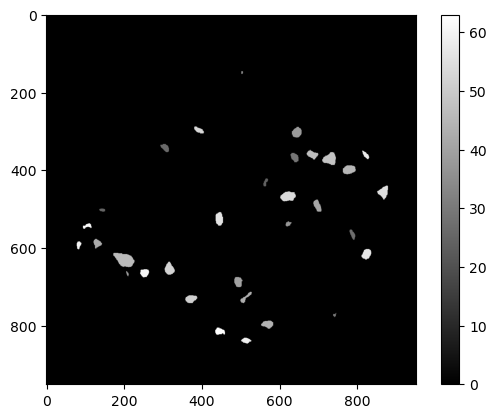

In [14]:
import zarr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr file or directory
zarr_file = zarr.open(r'C:\Senior_Design\outputs\zarr\original_dataset\Slag3\Slag3.zarr', mode='r')  # 'r' for read-only
print(zarr_file)
print(zarr_file.dtype)

arr = np.array(zarr_file)
# Display a slice of the 3D array
slice_index = 50  # Adjust this index based on your dataset
plt.imshow(arr[slice_index], cmap='gray')  # Display the slice
plt.colorbar()
plt.show()

<zarr.core.Array (747, 951, 951) float64 read-only>
float64


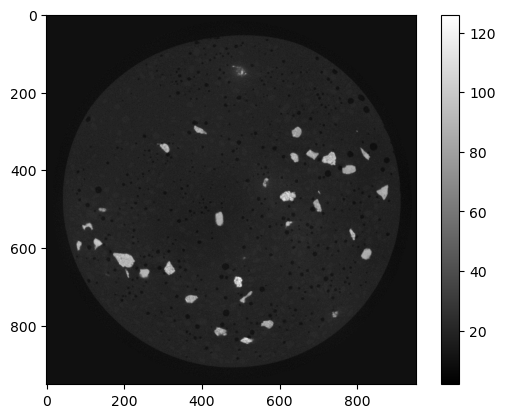

In [18]:
import zarr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr file or directory
zarr_file = zarr.open(r'C:\Senior_Design\database\original_dataset\zarr\Slag3.zarr', mode='r')  # 'r' for read-only
print(zarr_file)
print(zarr_file.dtype)

arr = np.array(zarr_file)
# Display a slice of the 3D array
slice_index = 50  # Adjust this index based on your dataset
plt.imshow(arr[slice_index], cmap='gray')  # Display the slice
plt.colorbar()
plt.show()

In [22]:
from PIL import Image
import numpy as np

# Open the TIFF file
tiff_image = Image.open(r'C:\Senior_Design\database\original_dataset\tiff\Slag3\slice_50.tiff')

# Convert to a NumPy array
image_array = np.array(tiff_image)

# Print the dtype and shape of the image
print("Data type (dtype):", image_array.dtype)
print("Image shape:", image_array.shape)

# Display the image
tiff_image.show()


Data type (dtype): uint8
Image shape: (951, 951)


In [32]:
from PIL import Image
import numpy as np

# Open the TIFF file
tiff_image = Image.open(r'C:\Senior_Design\outputs\tiff\original_dataset\Slag3\50.tiff')

# Convert to a NumPy array
image_array = np.array(tiff_image)

# Print the dtype and shape of the image
print("Data type (dtype):", image_array.dtype)
print("Image shape:", image_array.shape)

# Display the image
tiff_image.show()


UnidentifiedImageError: cannot identify image file 'C:\\Senior_Design\\outputs\\tiff\\original_dataset\\Slag3\\50.tiff'